In [1]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
from src.toolkit import compute_dissimilarity
import DSA
import similarity
import pickle
import numpy as np
import ipdb
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Load config

In [2]:
config = load_config("../config.yaml")

### Get dynamics

In [3]:
curves = {"frozen_pretrained": [], "unfrozen_pretrained": [], "frozen_unpretrained": [], "unfrozen_unpretrained": []}
explained_variances = {"frozen_pretrained": [], "unfrozen_pretrained": [], "frozen_unpretrained": [], "unfrozen_unpretrained": []}
curves_names = {"frozen_pretrained": [], "unfrozen_pretrained": [], "frozen_unpretrained": [], "unfrozen_unpretrained": []}
dissimilarities = {}
for activation in config["rnn"]["parameters"]["activations"]:
    for hidden_size in config["rnn"]["parameters"]["n_rnn"]:
        for lr in config["rnn"]["parameters"]["learning_rate"]:
            for freeze in config["rnn"]["parameters"]["freeze"]:
                for nopretraining in config["rnn"]["parameters"]["nopretrain"]:
                    curve, explained_variance = compute_dissimilarity(
                        activation, hidden_size, lr, freeze, nopretraining, "cpu", n_components=3 
                    )
                    if freeze:
                        if nopretraining:
                            curves["frozen_unpretrained"].append(curve)
                            explained_variances["frozen_unpretrained"].append(explained_variance)
                            curves_names["frozen_unpretrained"].append(
                                f"{activation}_{hidden_size}_{lr}_frozen_unpretrained"
                            )
                        else:
                            curves["frozen_pretrained"].append(curve)
                            explained_variances["frozen_pretrained"].append(explained_variance)
                            curves_names["frozen_pretrained"].append(
                                f"{activation}_{hidden_size}_{lr}_frozen_pretrained"
                            )

                    else:
                        if nopretraining:
                            curves["unfrozen_unpretrained"].append(curve)
                            explained_variances["unfrozen_unpretrained"].append(explained_variance)
                            curves_names["unfrozen_unpretrained"].append(
                                f"{activation}_{hidden_size}_{lr}_unfrozen_unpretrained"
                            )
                        else:
                            curves["unfrozen_pretrained"].append(curve)
                            explained_variances["unfrozen_pretrained"].append(explained_variance)
                            curves_names["unfrozen_pretrained"].append(
                                f"{activation}_{hidden_size}_{lr}_unfrozen_pretrained"
                            )






/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(
/Users/qguilhot/Library/Caches/pypoetry/virtualenvs/multitask-rnn-kKi2hSus-py3.11/lib/python3.11/site-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead

In [4]:
curve.shape

(200, 200, 3)

### Explained Variance Analysis

#### Frozen models

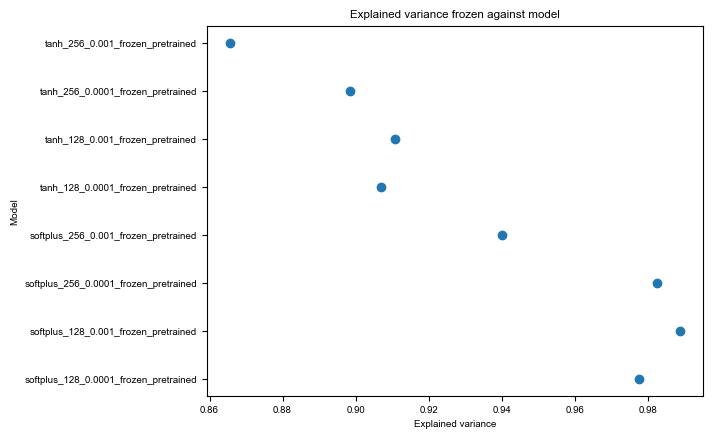

In [5]:
# plot explained variance frozen against curves frozen names
plt.figure()
plt.scatter(explained_variances["frozen_pretrained"], curves_names["frozen_pretrained"])
plt.xlabel("Explained variance")
plt.ylabel("Model")
plt.title("Explained variance frozen against model")
plt.show()

### Visualize curves frozen pretrained

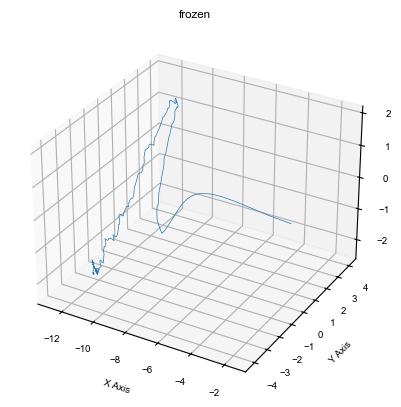

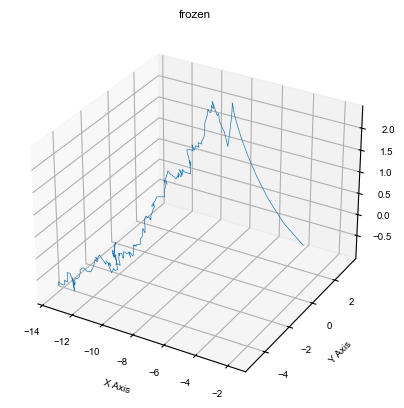

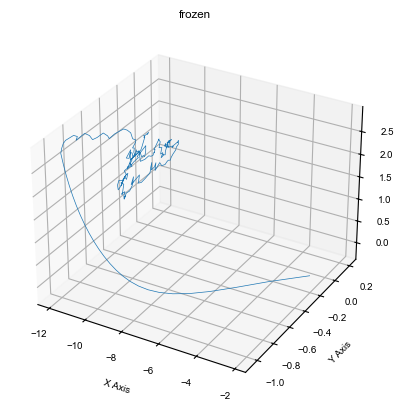

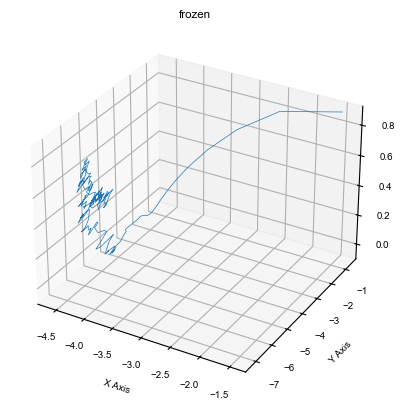

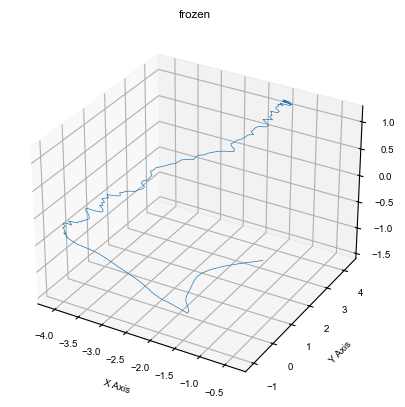

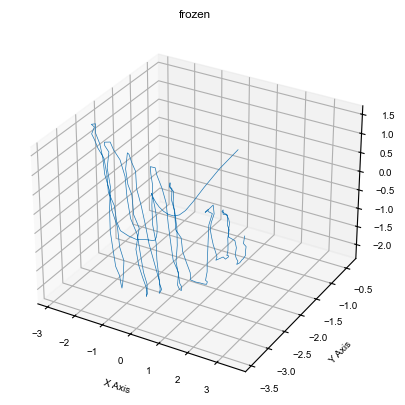

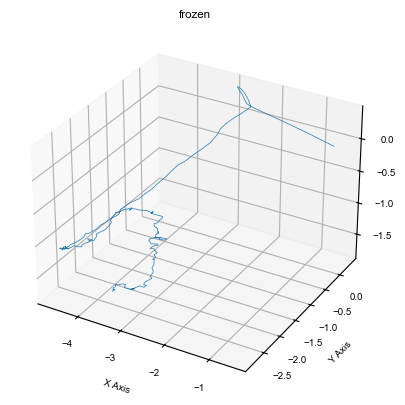

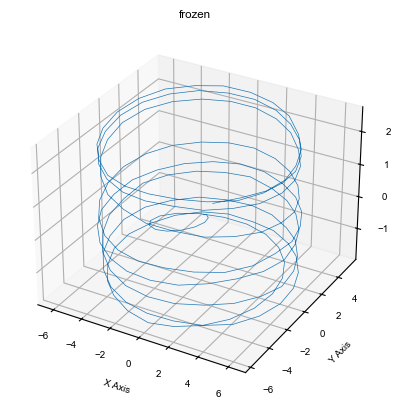

In [6]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves["frozen_pretrained"]], f"frozen")

### Visualize curves unfrozen pretrained

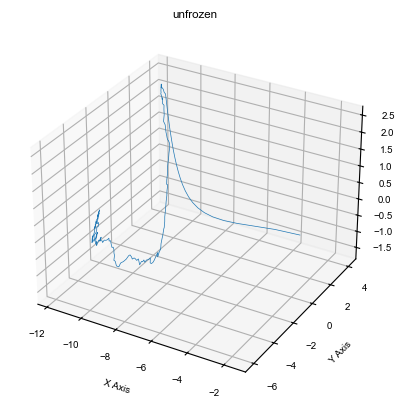

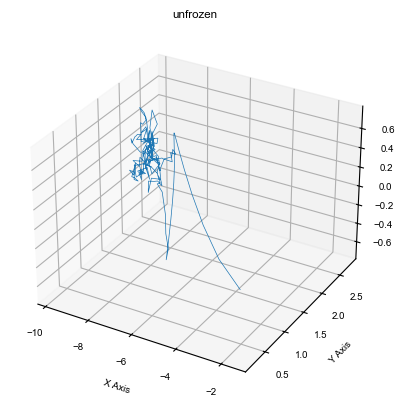

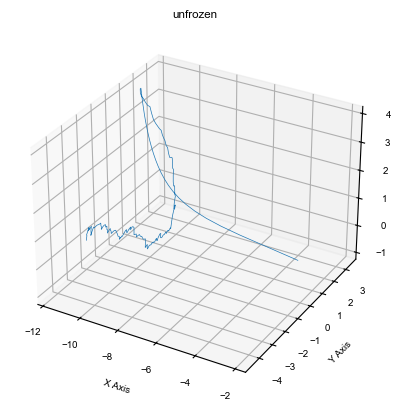

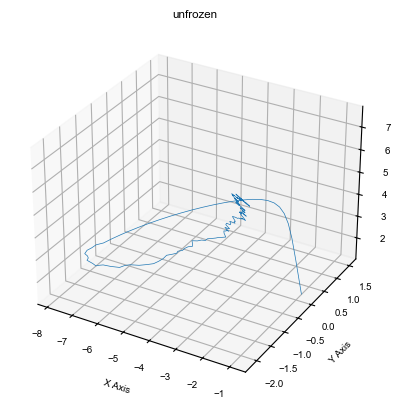

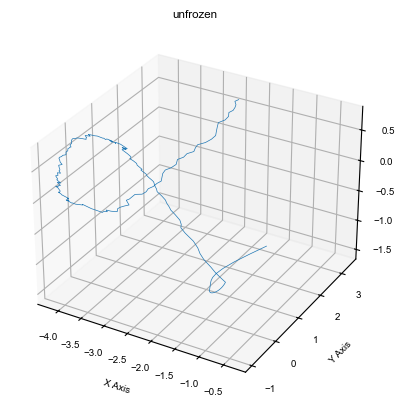

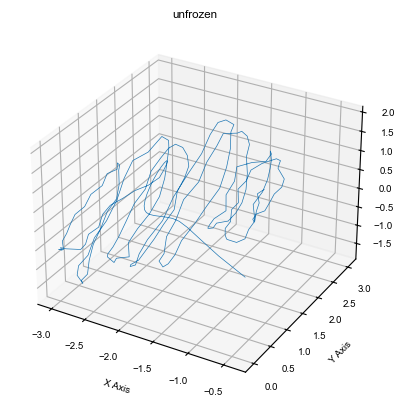

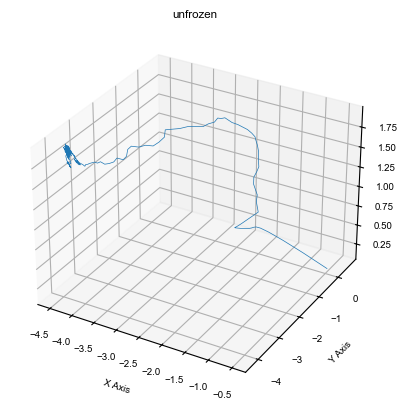

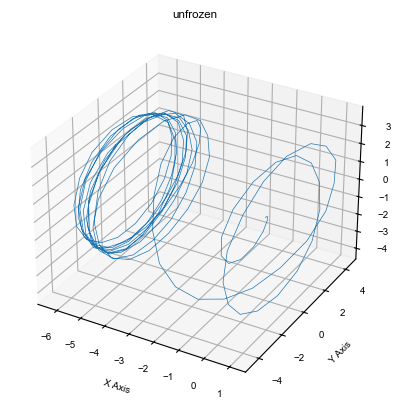

In [7]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves["unfrozen_pretrained"]], f"unfrozen")

#### frozen unpretrained

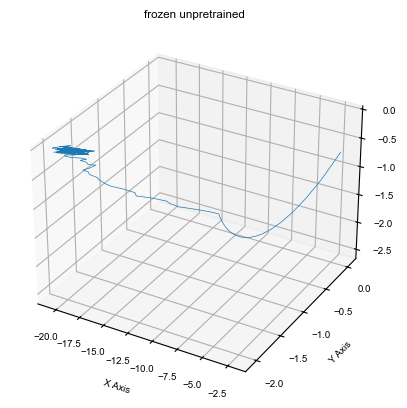

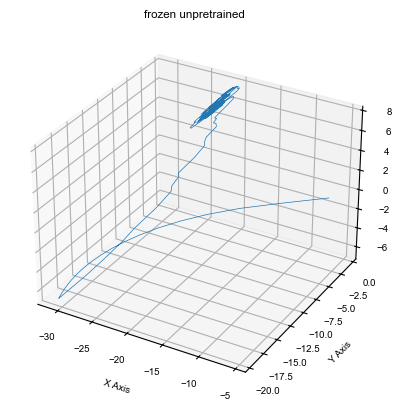

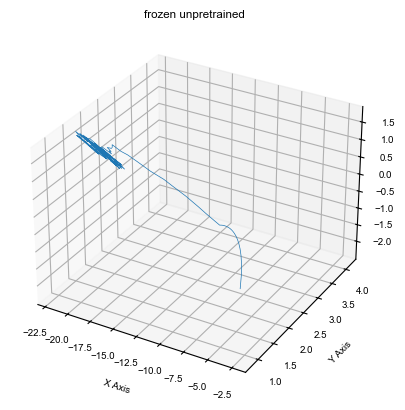

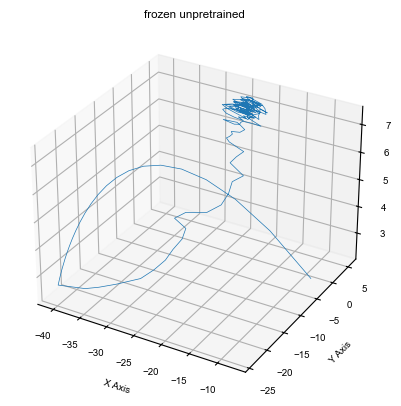

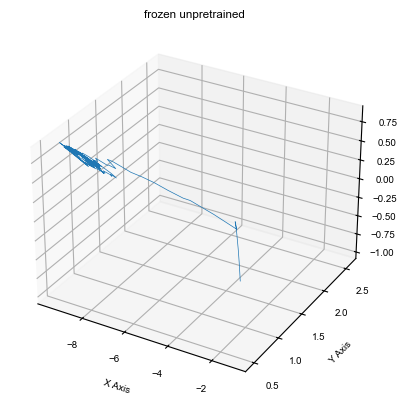

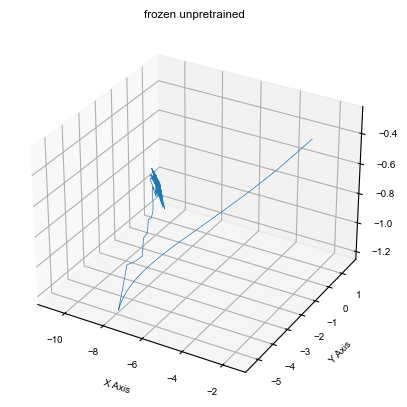

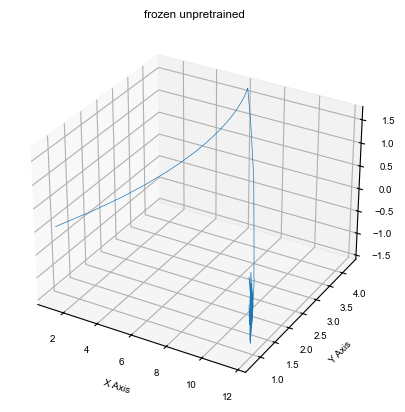

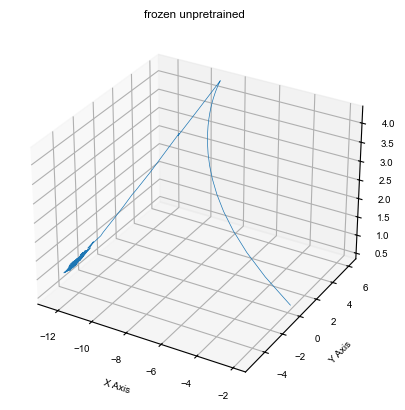

In [8]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves["frozen_unpretrained"]], f"frozen unpretrained")

#### Unfrozen unpretrained

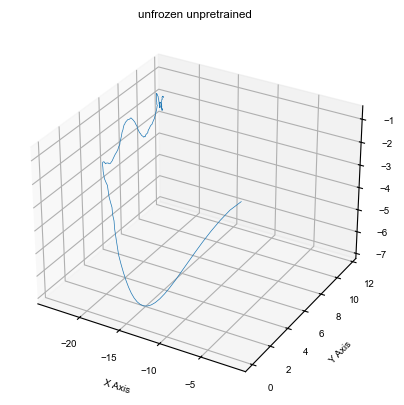

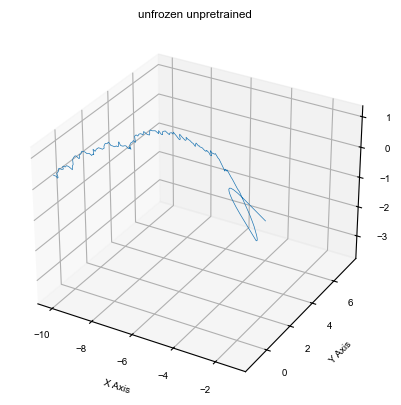

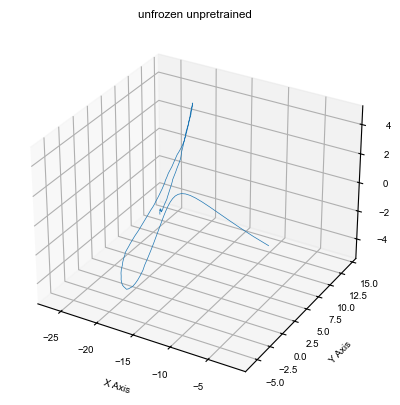

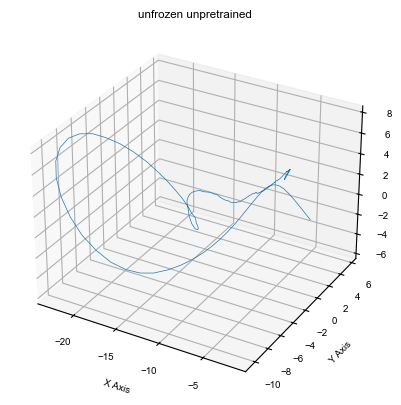

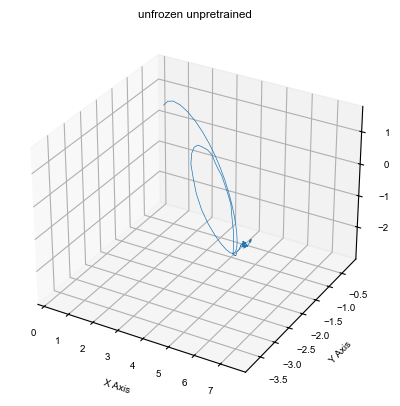

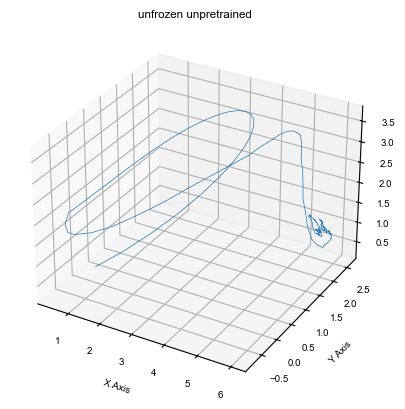

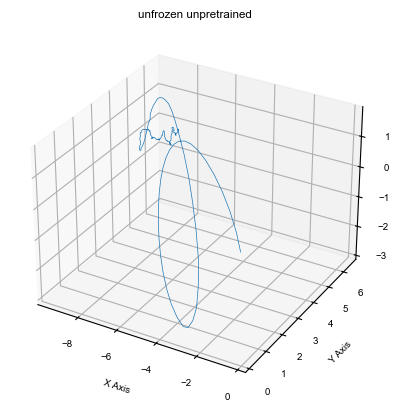

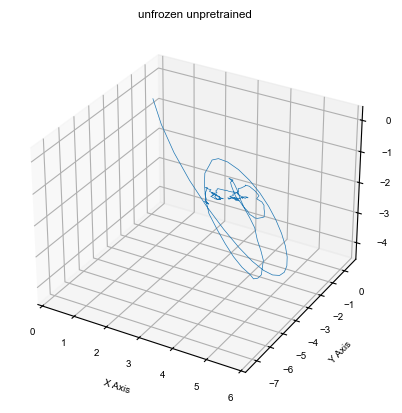

In [9]:
# for each curve in frozen, visualize the curve
visualize([curve[:,0,:] for curve in curves["unfrozen_unpretrained"]], f"unfrozen unpretrained")

### Get dissimilarities

In [10]:
def measure_dissimilarities(group1, group2):
    cka_measure = similarity.make("measure.sim_metric.cka-angular-score")
    procrustes_measure = similarity.make("measure.netrep.procrustes-angular-score")
    dis_cka = np.empty((len(group1), len(group2)))
    dis_procrustes = np.empty((len(group1), len(group2)))
    for i, model1 in enumerate(group1):
        for j, model2 in enumerate(group2):
            dis_cka[i, j] = 1 - cka_measure(model1, model2)
            # test if nan otherwise replace by 1
            dis_procrustes[i, j] = 1- procrustes_measure(model1, model2)
    dsa_comp = DSA.DSA(
        group1, group2,
        n_delays=config["dsa"]["n_delays"],
        rank=config["dsa"]["rank"],
        delay_interval=config["dsa"]["delay_interval"],
        verbose=True,
        iters=1000,
        lr=1e-2,
    )
    dis_dsa = dsa_comp.fit_score()
    return {"cka":dis_cka, "procrusts":dis_procrustes, "dsa":dis_dsa}

In [11]:
for key1 in curves.keys():
    for key2 in curves.keys():
        # check if the dissimilarity has not been computed yet
        if (f"{key1}VS{key2}" or f"{key2}VS{key1}") not in dissimilarities.keys():
            dissimilarities[f"{key1}VS{key2}"]= measure_dissimilarities(curves[key1], curves[key2])
            dissimilarities[f"{key2}VS{key1}"]= dissimilarities[f"{key1}VS{key2}"]

arccos score: 1.0000000077781817 nan 7.77818165431654e-09
arccos score: 0.048150919955831095 1.522626780992604 0.9518490800441689
arccos score: 0.0422192722983904 1.528564502015814 0.9577807277016096
arccos score: 0.029458601730475653 1.5413334626586697 0.9705413982695243
arccos score: 0.12393747049719084 1.4465393526702295 0.8760625295028092
arccos score: 0.047727182631893794 1.5230510060671185 0.9522728173681062
arccos score: 0.03628403107593392 1.534504329490474 0.9637159689240661
arccos score: 0.015572674025226774 1.5552230232841762 0.9844273259747732
arccos score: 0.048150919955831095 1.522626780992604 0.9518490800441689
arccos score: 1.0000000296094385 nan 2.9609438456645876e-08
arccos score: 0.021276409776834426 1.5495183114368698 0.9787235902231656
arccos score: 0.09517474529199965 1.4754773068097562 0.9048252547080003
arccos score: 0.08061354962915446 1.4900952090555348 0.9193864503708455
arccos score: 0.016512691575675476 1.5542828847106593 0.9834873084243245
arccos score: 0.

In [12]:
dissimilarities

{'frozen_pretrainedVSfrozen_pretrained': {'cka': array([[           nan, 9.69334315e-01, 9.73114385e-01, 9.81243358e-01,
          9.20895553e-01, 9.69604385e-01, 9.76895797e-01, 9.90085727e-01],
         [9.69334315e-01,            nan, 9.86453995e-01, 9.39318027e-01,
          9.48624073e-01, 9.89487216e-01, 9.64927303e-01, 9.89990198e-01],
         [9.73114385e-01, 9.86453995e-01,            nan, 9.87541412e-01,
          9.89189414e-01, 9.94563772e-01, 9.89334247e-01, 9.98767664e-01],
         [9.81243358e-01, 9.39318027e-01, 9.87541412e-01, 1.09220160e-04,
          9.76992108e-01, 9.96985898e-01, 9.89184127e-01, 9.97168331e-01],
         [9.20895553e-01, 9.48624073e-01, 9.89189414e-01, 9.76992108e-01,
                     nan, 9.79445501e-01, 9.64295212e-01, 9.90805663e-01],
         [9.69604385e-01, 9.89487216e-01, 9.94563771e-01, 9.96985898e-01,
          9.79445501e-01, 8.81596513e-05, 9.66569156e-01, 9.92845123e-01],
         [9.76895797e-01, 9.64927303e-01, 9.89334247e-01, 9

### Plot dissimilarities within and across groups

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `dissimilarities` is a dictionary with the computed dissimilarities


# Function to compute mean, median, and quartiles, excluding the diagonal for within-group comparisons
def compute_stats(dissimilarities, measure, groups):
    stats = {}
    for group in groups:
        dis_values = dissimilarities[group][measure]
        # # Mask the diagonal
        dis_values = dis_values[~np.eye(dis_values.shape[0], dtype=bool)]

        stats[group] = {
            "median": np.median(dis_values),
            "q1": np.percentile(dis_values, 25),
            "q3": np.percentile(dis_values, 75),
        }
    return stats

# Function to plot the stats with error bars for quartiles
def plot_stats(stats, measure_name):
    groups = list(stats.keys())
    medians = np.array([stats[group]["median"] for group in groups])
    q1s = np.array([stats[group]["q1"] for group in groups])
    q3s = np.array([stats[group]["q3"] for group in groups])

    x = np.arange(len(groups))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects2 = ax.bar(
        x + width / 2,
        medians,
        width,
        label="Median",
        yerr=[medians - q1s, q3s - medians],
        capsize=5,
    )

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel("Groups")
    ax.set_ylabel("Similarity")
    ax.set_title(f"Mean and Median Similarities for {measure_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()

    fig.tight_layout()
    plt.show()


In [14]:
groups = dissimilarities.keys()
groups = ["unfrozen_unpretrainedVSunfrozen_unpretrained", "unfrozen_pretrainedVSunfrozen_pretrained", "unfrozen_pretrainedVSunfrozen_unpretrained"]

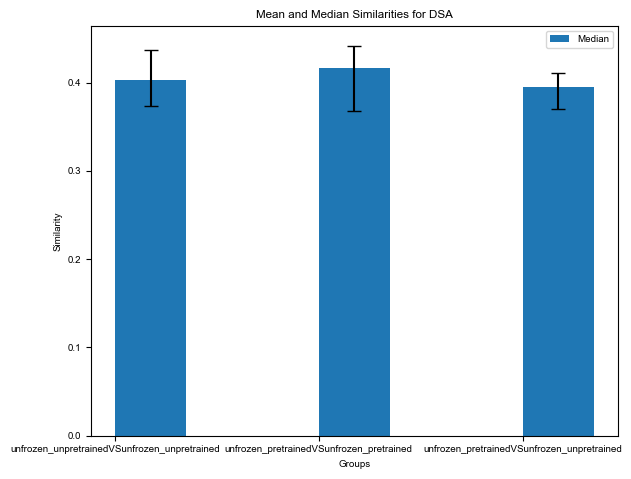

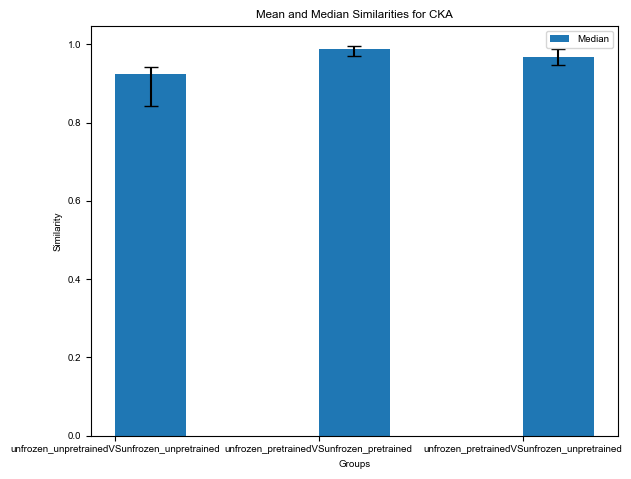

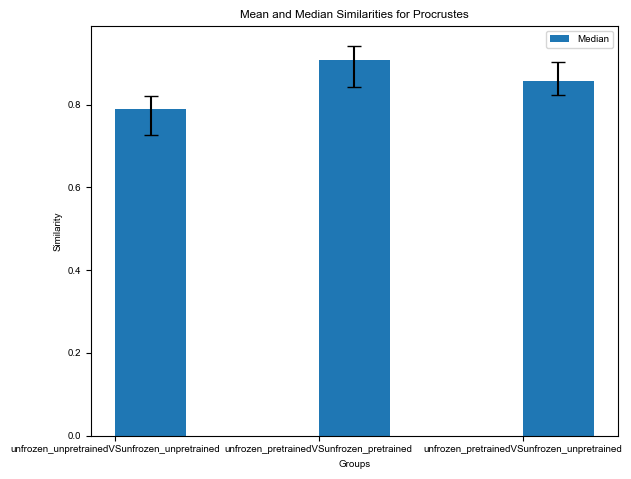

In [15]:
# Compute stats for each measure
stats_dsa = compute_stats(dissimilarities, "dsa", groups)
stats_cka = compute_stats(dissimilarities, "cka", groups)
stats_procrustes = compute_stats(dissimilarities, "procrusts", groups)

# Plot stats for each measure
plot_stats(stats_dsa, "DSA")
plot_stats(stats_cka, "CKA")
plot_stats(stats_procrustes, "Procrustes")

In [16]:
# want to create an array of shape (4,4,3) where the first dimension is the group1, the second dimension is the group2 and the third dimension is the measure

dissimilarities_groups = np.empty((4,4,3))
groups = ["frozen_pretrained", "unfrozen_pretrained", "frozen_unpretrained", "unfrozen_unpretrained"]
measures = ["dsa", "cka", "procrusts"]
for i, group1 in enumerate(groups):
    for j, group2 in enumerate(groups):
        for k, measure in enumerate(measures):
            dis_values = dissimilarities[f"{group1}VS{group2}"][measure]
            dis_values[~np.eye(dis_values.shape[0], dtype=bool)]
            dissimilarities_groups[i,j,k] = np.median(dis_values)

# save the dissimilarities
with open("dissimilarities_groups.pkl", "wb") as f:
    pickle.dump(dissimilarities_groups, f)
        
                

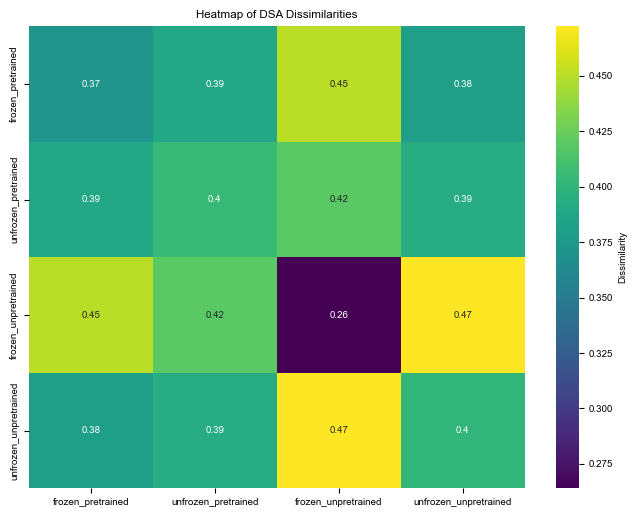

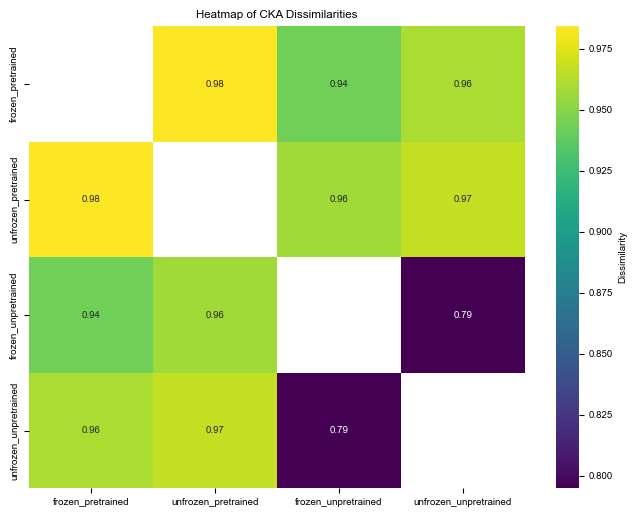

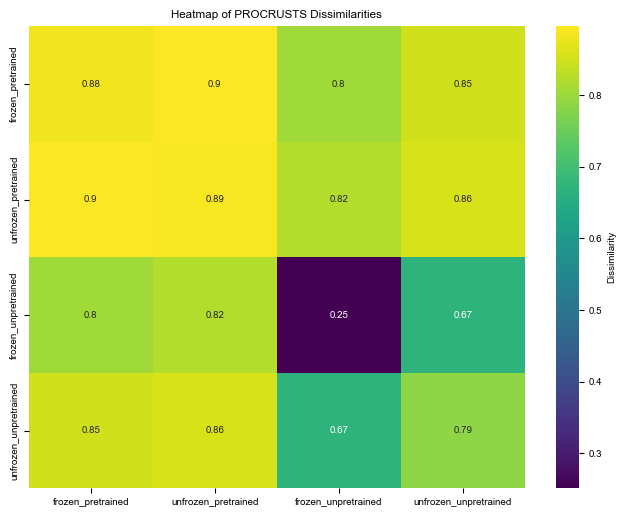

In [17]:
# Create a heatmap for each measure
import pandas as pd

for k, measure in enumerate(measures):
    data = dissimilarities_groups[:, :, k]
    df = pd.DataFrame(data, index=groups, columns=groups)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, cmap="viridis", cbar_kws={'label': 'Dissimilarity'})
    plt.title(f'Heatmap of {measure.upper()} Dissimilarities')
    plt.show()